In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
# assert len(physical_devices) == 3
# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
from dotmap import DotMap

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [ ]:
tf.constant([[1,2],[3,4],[4, 5]])

In [ ]:
import models
import training
import datasets
import vizualization
import schedules

# todo
# - combine shuffled and unshuffled datasets into same thing
# - add extra shuffled indices and noise
# - add "noise fraction" parameter which can be changed the same way as the "n" parameter.
# - add different amounts of noise to the data and see what happens

In [ ]:
config = DotMap({
    'ds': 'mnist',
    'distributed': False,
    'minibatch_size': 48,
    'n_steps': 120001,
    'test_size': 300,
    'test_minibatch_size': 100,
    'test_interval': 5000,
    'test_n_shuf': [1, 64, 128, 256],
    'test_n_seq': [1, 128, 256, 512],
    'test_autoregressive': False,
    'noise_fraction': 0,
    'display_images': True,
    'display_image_interval': 5000,
    'dont_display_until_loss': 0.45,
    'bg_color': [1.0, 0.4, 0.6],
    'lr_schedule': None,
    'lr_warmup_steps': 300,
    'max_lr': 0.0001,
    'min_lr': 0.0001,
    'grad_accum_steps': None, #['exponential', 1, 4],
    'max_accum_steps': 4,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 500,
    'kmeans_batch_size': 1000,
})

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

In [4]:
gamma_dist, gamma_name = datasets.gamma_distribution_7x7()


In [5]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change

ds_configs = DotMap({
    'mnist': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'image_size': (28, 28),
    },
    'mnist_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'mnist_binary_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 2,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
})

config.dataset = ds_configs[config.ds]

dataset, metadata = tfds.load(config.dataset.name, with_info=True, as_supervised=True)

ds_train_original = dataset['train']
ds_test_original = dataset['test']

centroids = datasets.find_centroids(config, ds_train_original)

ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)
ds_train, ds_test = ds.make_datasets()


centroids.shape (4, 1)


Not using gradient accumulation


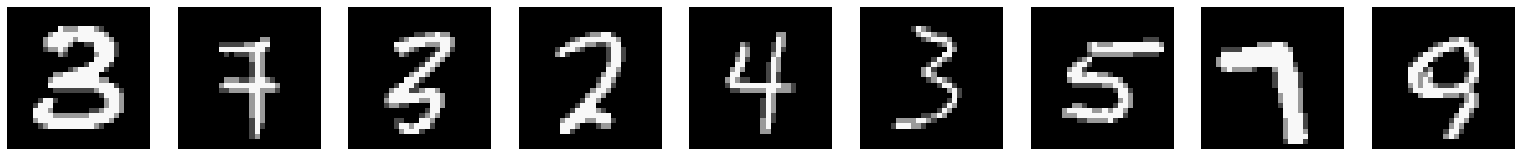

In [6]:
display_colors, display_idxs, *_ = next(iter(ds_train))
if config.grad_accum_steps:
    display_colors,display_idxs = display_colors[0],display_idxs[0]
viz.showSeq(display_colors, display_idxs, config.dataset.image_size, max_images=9)

In [ ]:


# model config
config.model = DotMap({
    'n_colors': config.dataset.n_colors,
    'n_color_dims': config.dataset.n_color_dims,
    'n_enc_a_layers': 3,
    'n_enc_b_layers': 3,
    'ffl_dim': 800,
    'embd_dim': 512,
    'n_dec_layers': 3,
    'dec_dim': 600,
    'n_heads': 4,
    'dropout_rate': 0.1,
    'use_idxs_input': True,
    'architecture': 'anp',
    'position_embedding': 'pos_enc',
    'activation': 'swish',
})

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = models.transformer(config.model)
    # Adam params taken from the linked notebook
    optimizer = keras.optimizers.Adam(learning_rate=config.max_lr)

ds_train_dist = strategy.experimental_distribute_dataset(ds_train)

config.training_mode = 'combination'

model_name = models.model_name('cuda2', config)
print(model_name)

evaler = training.Evaluator(config, model, optimizer, viz, ds, ds_train_dist, ds_test)

training_loop = training.TrainingLoop(config, evaler, model_name)

with strategy.scope():
    training_loop.train()

In [ ]:
model.save(f"models/{model_name}")

In [ ]:
training_loop.process_batch(show_input=True)
training_loop.new_test_batch()
training_loop.process_batch(show_input=True)
